### Using what we have made for understanding the look time

#### I want to clean up the stacked view and then also see if we can bin into segments and show as a proportion of data points that are looking in that section of time

In [9]:
## from ExploringLookTimeandClass basic function for looping over data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional

def _extract_adc_headers(hdr_path: Path):
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                return [h.strip() for h in line.split(":", 1)[1].split(",")]
    raise ValueError(f"ADCFileFormat not found in header file: {hdr_path}")

def _load_adc_for_timeline(adc_path: Path, hdr_path: Path) -> pd.DataFrame:
    headers = _extract_adc_headers(hdr_path)
    df = pd.read_csv(adc_path, header=None)
    df.columns = headers[:df.shape[1]]
    # ensure numeric
    df['RunTime'] = pd.to_numeric(df['RunTime'], errors='coerce')
    df['InhibitTime'] = pd.to_numeric(df['InhibitTime'], errors='coerce')
    df = df.dropna(subset=['RunTime','InhibitTime']).sort_values('RunTime').reset_index(drop=True)
    return df

def plot_directory_timelines_time_inhibit_first(
    data_dir: str,
    abs_tol: float = 1e-6,
    save_path: Optional[str] = None,
    max_files: Optional[int] = None,
):
    """
    Scan a directory for *.hdr / *.adc pairs and plot a single figure with
    a horizontal 'state' strip per sample (red=inhibited first, blue=running).
    Returns a summary DataFrame with totals per sample.

    Parameters
    ----------
    data_dir : str
        Directory to scan recursively.
    abs_tol : float
        Small threshold to treat tiny ΔInhibit as zero (jitter).
    save_path : str or None
        If set, save the figure here (e.g., 'stacked_timelines.png').
    max_files : int or None
        Limit number of samples to plot (useful for quick previews).

    Returns
    -------
    summary_df : pd.DataFrame with columns:
        ['Sample', 'total_elapsed_s', 'total_running_s', 'total_inhibited_s',
         'final_runtime_s', 'final_inhibittime_s']
    """
    data_path = Path(data_dir)
    records = []  # (sample_name, df)

    # find hdr/adc pairs
    for hdr in sorted(data_path.rglob("*.hdr")):
        adc = hdr.with_suffix(".adc")
        if not adc.exists():
            continue
        try:
            df = _load_adc_for_timeline(adc, hdr)
            if len(df) >= 2:
                records.append((hdr.stem, df))
        except Exception as e:
            print(f"Skipping {hdr.stem}: {e}")

        if max_files and len(records) >= max_files:
            break

    if not records:
        print("No valid ADC/HDR pairs found.")
        return pd.DataFrame(columns=[
            'Sample','total_elapsed_s','total_running_s','total_inhibited_s',
            'final_runtime_s','final_inhibittime_s'
        ])

    # Determine global x-limit (max RunTime across samples)
    xmax = max(float(df['RunTime'].max()) for _, df in records)

    # One axes, stack rows by y offset (0..N-1)
    fig, ax = plt.subplots(figsize=(14, 1.1 * len(records) + 1))
    ytick_locs, ytick_labels = [], []

    summaries = []

    for row_idx, (name, df) in enumerate(records):
        line_spacing = 0.2  # smaller = closer lines, default was 1.0
        y0 = float(row_idx) * line_spacing

        # deltas
        dt = df['RunTime'].diff().to_numpy()
        dI = df['InhibitTime'].diff().to_numpy()

        # jitter & clamp
        dI = np.where(dI > abs_tol, dI, 0.0)
        dt = np.where(np.isfinite(dt), dt, 0.0)
        dI = np.where(np.isfinite(dI), dI, 0.0)
        dt = np.where(dt < 0, 0.0, dt)
        dI = np.clip(dI, 0.0, dt)

        x = df['RunTime'].to_numpy()
        total_inhib = 0.0
        total_run = 0.0

        # draw: inhibited (red) first, then running (blue)
        for i in range(1, len(df)):
            x0 = float(x[i-1]); x1 = float(x[i])
            if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
                continue
            di = float(dI[i])
            dr = float(dt[i] - di)

            cur = x0
            if di > 0:
                ax.plot([cur, cur+di], [y0, y0], color='red', linewidth=20, solid_capstyle='butt')
                cur += di
                total_inhib += di
            if dr > 0:
                ax.plot([cur, x1], [y0, y0], color='blue', linewidth=20, solid_capstyle='butt')
                total_run += dr

        ytick_locs.append(y0)
        ytick_labels.append(name)

        summaries.append({
            'Sample': name,
            'total_elapsed_s': total_run + total_inhib,
            'total_running_s': total_run,
            'total_inhibited_s': total_inhib,
            'final_runtime_s': float(df['RunTime'].iloc[-1]),
            'final_inhibittime_s': float(df['InhibitTime'].iloc[-1]),
        })

    # Style axes
    ax.set_xlim(0, xmax)
    ax.set_ylim(-line_spacing, len(records) * line_spacing)
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels(ytick_labels, fontsize=9)
    ax.set_xlabel("Run Time (s)")
    ax.set_title("Instrument State Over Time (red = inhibited first, blue = running/waiting)")
    ax.grid(False)
    for sp in ['right','top']:
        ax.spines[sp].set_visible(False)

    # # Make a tiny legend line
    # leg_x0, leg_y = xmax * 0.02, len(records) - 0.8
    # ax.plot([leg_x0, leg_x0 + xmax*0.06], [leg_y, leg_y], color='red', linewidth=6)
    # ax.text(leg_x0 + xmax*0.07, leg_y, "Inhibited", va='center', fontsize=9)
    # leg_y2 = leg_y - 0.5
    # ax.plot([leg_x0, leg_x0 + xmax*0.06], [leg_y2, leg_y2], color='blue', linewidth=6)
    # ax.text(leg_x0 + xmax*0.07, leg_y2, "Running/Waiting", va='center', fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved stacked timeline to: {save_path}")
    plt.show()

    summary_df = pd.DataFrame(summaries).sort_values('Sample').reset_index(drop=True)
    return summary_df


Saved stacked timeline to: ../Figs/spawn/zygotes_looktime.png


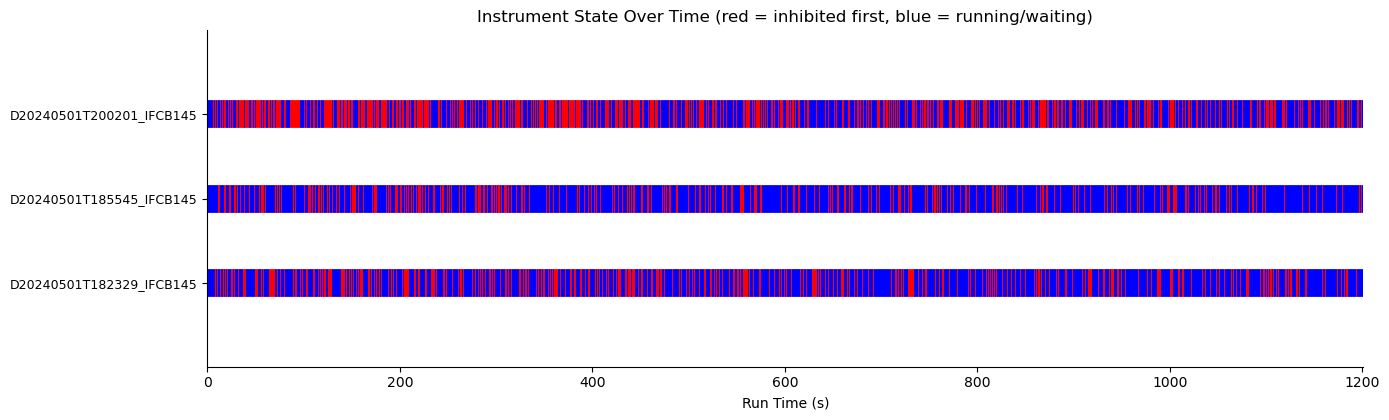

                     Sample  total_elapsed_s  total_running_s  \
0  D20240501T182329_IFCB145      1200.866747       821.690697   
1  D20240501T185545_IFCB145      1200.820054       876.066406   
2  D20240501T200201_IFCB145      1200.928255       682.816994   

   total_inhibited_s  final_runtime_s  final_inhibittime_s  
0         379.176050      1200.947639           379.187222  
1         324.753648      1200.894444           324.764375  
2         518.111261      1201.000556           518.121875  


In [10]:
summary_dir = plot_directory_timelines_time_inhibit_first(
    data_dir= "../IFCBData/spawn/zygotes/",
    save_path= "../Figs/spawn/zygotes_looktime.png"
)
print(summary_dir)

In [11]:
print(summary_dir)

                     Sample  total_elapsed_s  total_running_s  \
0  D20240501T182329_IFCB145      1200.866747       821.690697   
1  D20240501T185545_IFCB145      1200.820054       876.066406   
2  D20240501T200201_IFCB145      1200.928255       682.816994   

   total_inhibited_s  final_runtime_s  final_inhibittime_s  
0         379.176050      1200.947639           379.187222  
1         324.753648      1200.894444           324.764375  
2         518.111261      1201.000556           518.121875  


In [7]:
## trying prob stuff

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- reuse your helpers ---
def _extract_adc_headers(hdr_path: Path):
    with open(hdr_path, 'r') as f:
        for line in f:
            if line.startswith("ADCFileFormat:"):
                return [h.strip() for h in line.split(":", 1)[1].split(",")]
    raise ValueError(f"ADCFileFormat not found in header file: {hdr_path}")

def _load_adc_for_timeline(adc_path: Path, hdr_path: Path) -> pd.DataFrame:
    headers = _extract_adc_headers(hdr_path)
    df = pd.read_csv(adc_path, header=None)
    df.columns = headers[:df.shape[1]]
    df['RunTime'] = pd.to_numeric(df['RunTime'], errors='coerce')
    df['InhibitTime'] = pd.to_numeric(df['InhibitTime'], errors='coerce')
    df = df.dropna(subset=['RunTime','InhibitTime']).sort_values('RunTime').reset_index(drop=True)
    return df

# --- build (name, df) records from a directory ---
def _collect_records(data_dir: str, max_files=None):
    data_path = Path(data_dir)
    records = []
    for hdr in sorted(data_path.rglob("*.hdr")):
        adc = hdr.with_suffix(".adc")
        if not adc.exists():
            continue
        try:
            df = _load_adc_for_timeline(adc, hdr)
            if len(df) >= 2:
                records.append((hdr.stem, df))
        except Exception as e:
            print(f"Skipping {hdr.stem}: {e}")
        if max_files and len(records) >= max_files:
            break
    return records

# --- compute per-time-bin proportions across many runs ---
def compute_proportion_inhibited(records, abs_tol=1e-6, bin_size=1.0):
    """
    records: list of (name, adc_df) with columns RunTime & InhibitTime.
    Returns a DataFrame with time_center_s, p_inhibited, p_running, n_active.
    """
    if not records:
        return pd.DataFrame(columns=['time_center_s','p_inhibited','p_running','n_active'])

    max_runtime = max(float(df['RunTime'].max()) for _, df in records)
    time_bins = np.arange(0, max_runtime + bin_size, bin_size)
    bin_centers = time_bins[:-1] + bin_size / 2

    inhibited_counts = np.zeros(len(bin_centers))
    active_counts = np.zeros(len(bin_centers))

    for _, df in records:
        dt = df['RunTime'].diff().to_numpy()
        dI = df['InhibitTime'].diff().to_numpy()

        # kill jitter & clamp
        dI = np.where(dI > abs_tol, dI, 0.0)
        dt = np.where(np.isfinite(dt), dt, 0.0)
        dI = np.where(np.isfinite(dI), dI, 0.0)
        dt = np.where(dt < 0, 0.0, dt)
        dI = np.clip(dI, 0.0, dt)

        # build (start, end, state) segments: red first (inhibit), then blue (run)
        x = df['RunTime'].to_numpy()
        segments = []
        for i in range(1, len(df)):
            x0 = float(x[i-1]); x1 = float(x[i])
            if not np.isfinite(x0) or not np.isfinite(x1) or x1 <= x0:
                continue
            di = float(dI[i]); dr = float(dt[i] - di)
            cur = x0
            if di > 0:
                segments.append((cur, cur+di, 'inhib')); cur += di
            if dr > 0:
                segments.append((cur, x1, 'run'))

        # bin coverage: count each bin touched by a segment
        for start, end, state in segments:
            if end <= start:
                continue
            start_bin = int(start // bin_size)
            end_bin = int((end - 1e-12) // bin_size)
            for b in range(max(0, start_bin), min(len(bin_centers)-1, end_bin)+1):
                active_counts[b] += 1
                if state == 'inhib':
                    inhibited_counts[b] += 1

    p_inhibited = np.divide(inhibited_counts, active_counts, out=np.zeros_like(inhibited_counts), where=active_counts>0)
    p_running = 1 - p_inhibited

    return pd.DataFrame({
        'time_center_s': bin_centers,
        'p_inhibited': p_inhibited,
        'p_running': p_running,
        'n_active': active_counts
    })

# --- plot a 1×N heat map bar of proportion inhibited over time ---
def plot_looktime_heatbar(
    data_dir: str,
    bin_size: float = 1.0,
    abs_tol: float = 1e-4,
    cmap: str = 'Reds',        # 0 (white/light) -> 1 (deep red)
    save_path: Optional[str] = None,
    max_files: Optional[int] = None,
    show_colorbar: bool = True,
    title: str = "Proportion Inhibited (Look Time) Over Time"
):
    """
    Builds a single heat-bar (1 x N bins) where color encodes the proportion inhibited (0..1).
    1 = all samples inhibited (looking), 0 = none inhibited (all running).
    """
    records = _collect_records(data_dir, max_files=max_files)
    if not records:
        print("No valid ADC/HDR pairs found.")
        return None

    prob_df = compute_proportion_inhibited(records, abs_tol=abs_tol, bin_size=bin_size)
    if prob_df.empty:
        print("No probability data computed.")
        return None

    # 2D image: shape (1, Nbins)
    img = prob_df['p_inhibited'].to_numpy()[np.newaxis, :]  # 1 x N
    t0 = prob_df['time_center_s'].iloc[0] - bin_size/2
    t1 = prob_df['time_center_s'].iloc[-1] + bin_size/2

    fig, ax = plt.subplots(figsize=(12, 1.4))
    im = ax.imshow(
        img,
        aspect='auto',
        interpolation='nearest',
        extent=[t0, t1, 0, 1],      # x spans time; y is dummy [0,1]
        vmin=0, vmax=1,
        cmap=cmap,
        origin='lower'
    )

    ax.set_yticks([])
    ax.set_xlabel("Time (s)")
    ax.set_title(title)
    ax.set_xlim(0, t1)
    for sp in ['left','right','top']:
        ax.spines[sp].set_visible(False)
    ax.grid(False)

    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax, pad=0.02)
        cbar.set_label("Proportion Inhibited (0–1)")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved heat-bar to: {save_path}")
    plt.show()

    return prob_df


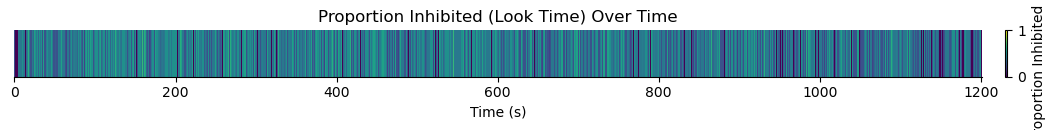

In [13]:
# Make the single heat-bar for your folder
prob_df = plot_looktime_heatbar(
    data_dir="../IFCBData/spawn/zygotes/",
    bin_size=0.1,                      # try 2–5 s for smoother color blocks
    abs_tol=1e-4,                      # suppress tiny ΔInhibit jitter
    cmap="viridis",                       # or 'viridis', 'plasma', etc.
    #save_path="../figs/looktime_heatbar.png",  # or None
    max_files=None,                    # or an int to limit files
    show_colorbar=True
)

# prob_df has the underlying numbers if you want downstream stats:
# columns: ['time_center_s', 'p_inhibited', 'p_running', 'n_active']


In [ ]:
so